<a href="https://colab.research.google.com/github/srishtipithadia/ProjectsInMLandAI/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
**Homework 2: Ensemble Learning**

*   By: Srishti Pithadia
*   Date: September 23rd, 2022


---


**Task 0: Summarized Prep of Dataset (Copied from HW1)**

In [1]:
# importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from math import exp
import math
import warnings
warnings.filterwarnings("ignore")

#link: https://www.kaggle.com/datasets/zzettrkalpakbal/full-filled-brain-stroke-dataset
df = pd.read_csv('full_data.csv')

# viewing the first few rows of the data
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [2]:
# checking to see if there are any missing vals in the dataset
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [3]:
# seeing if the data imbalanced
df.stroke.value_counts(normalize=True) #normalizes the result

0    0.950211
1    0.049789
Name: stroke, dtype: float64

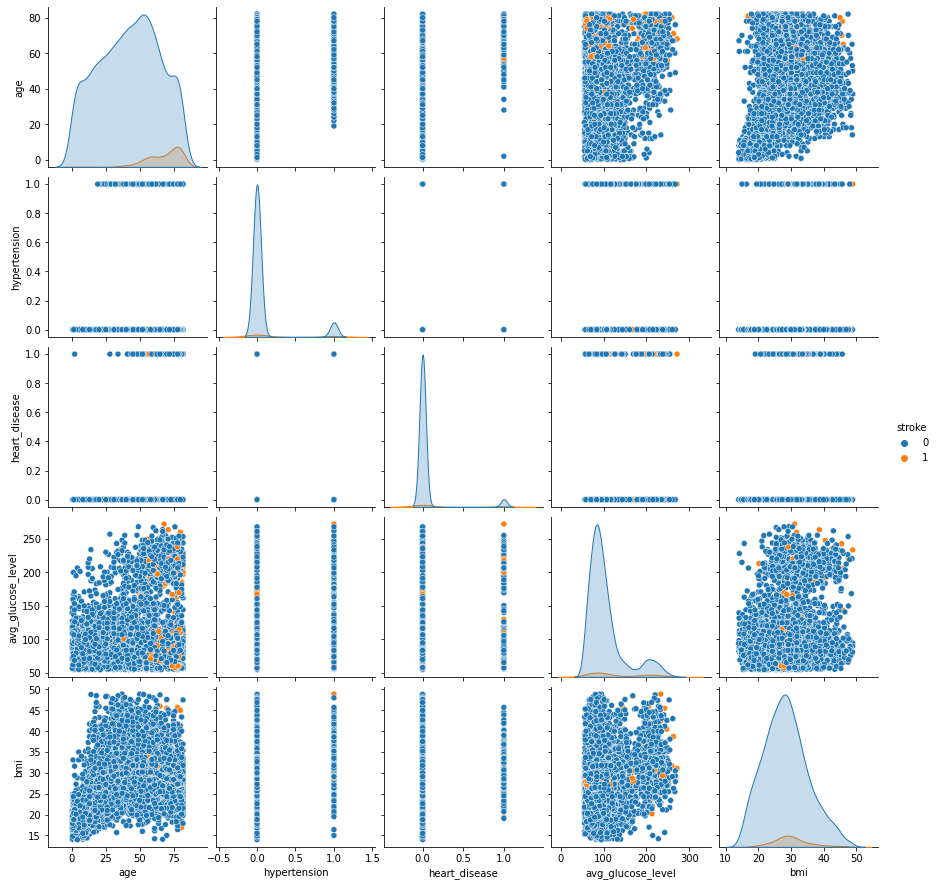

In [4]:
# plotting pairwise relationships in the dataset
sns.pairplot(df, hue='stroke')

In [5]:
# splitting the dataset by stroke/not and getting the mean value of other numeric variables for each group 
df.groupby('stroke').mean()

,age,hypertension,heart_disease,avg_glucose_level,bmi
stroke,,,,,
0,42.141348,0.087260,0.048172,104.569056,28.409698
1,67.819839,0.266129,0.189516,132.175565,30.186694


In [6]:
# breaking down into age categories (by 10 years) for easier trend observation later
bins = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109, np.inf]
labels = [lbl for lbl in range(len(bins)-1)]
df['AgeCategory'] = pd.cut(df.age, bins=bins, labels=labels, right=True).astype(int)

In [7]:
# performing label encoding for all the 2 option categorical columns so that feature scaling can work

# ever married var
df.ever_married = df.ever_married.map({ 'No': 0, 'Yes': 1 })

# gender var
df.gender = df.gender.map({ 'Male': 0, 'Female': 1 })

# residence type var
df.Residence_type = df.Residence_type.map({ 'Rural': 0, 'Urban': 1 })

In [8]:
# performing hot encoding for categorical columns with >2 options
for column in ['work_type']:
    dummies = pd.get_dummies(df[column])
    df = pd.concat([df, dummies], axis=1).drop([column], axis=1)

In [9]:
# dropping columns that don't make sense 
# smoking has 'unknown' as an option, which isn't helpful
df.drop(['smoking_status'], axis=1, inplace=True)

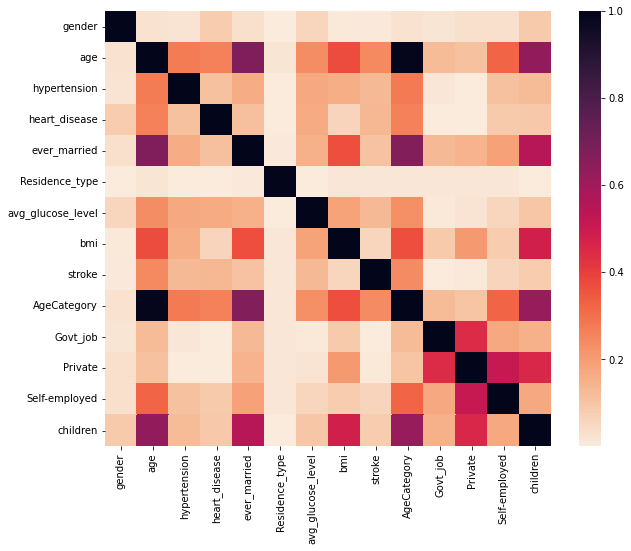

In [10]:
# seeing how our features correlate with each other
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr().abs(),annot=False, ax=ax, cmap='rocket_r')

In [11]:
# seeing how our features correlate with each other and with the target variable ('stroke')
df.corr()['stroke'].sort_values(ascending=False)

stroke               1.000000
age                  0.246478
AgeCategory          0.242041
heart_disease        0.134610
avg_glucose_level    0.133227
hypertension         0.131965
ever_married         0.108398
Self-employed        0.062643
bmi                  0.056926
Residence_type       0.016494
Private              0.010459
Govt_job             0.002574
gender              -0.008870
children            -0.085075
Name: stroke, dtype: float64

In [12]:
X = df.drop(['stroke'], axis=1)   # independent variables
y = df.stroke                     # dependent/target variable

# dividing the data into 'train' and 'test' sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# scaling the data between 0 and 1
transformer = Normalizer(norm='max').fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

**Task 1: Implement Decision Tree Classifier**

In [14]:
# decision tree classifier with all params to be tested
def general_dtc(X, Y, X_test, c, s, r, d, l, ss):
    dtc = DecisionTreeClassifier(criterion = c, splitter = s, random_state = r, max_depth = d, min_samples_leaf = l, min_samples_split = ss) 
    dtc.fit(X, Y)
    y_pred = dtc.predict(X_test)
    return accuracy_score(y_test, y_pred)    # returns accuracy score

In [15]:
# plotting methods

# returns a list of 75 accuracy scores for 75 DTC runs
def average_accuracy(c = 'gini', s = 'best', r = None, d = None, l = 1, ss = 2, version = 1):
    # initialize vars
    all_scores = []
    start_i = 1

    # max_depth & min_samples_leaf can't be 0 but random_state can, and min_samples_split can't be 0 or 1, only 2
    if r is True:
        start_i = 0
    elif ss is True:
        start_i = 2

    # loop through x75 
    for i in range(start_i, start_i+75):

        # if random_state, max_depth, min_samples_leaf, or min_samples_split are the observed param, then value iterates 0/1-75
        if r is True:
            r = i
        elif d is True:
            d = i
        elif l is True:
            l = i
        elif ss is True:
            ss = i

        # get accuracy score, add to sum of scores, and add to list of scores
        acc_score = general_dtc(X_train, y_train, X_test, c, s, r, d, l, ss)
        all_scores.append(acc_score)

    # print average of all accuracy scores
    print('Version {} Average Accuracy Score:  {}'.format(version, mean(all_scores)))
    print('Version {} Standard Deviation:      {}\n'.format(version, std(all_scores)))

    # return list of all accuracy scores collected
    return all_scores


# plots a graph comparing 2 different values for a param
def plot_accuracy_comparison(c1 = 'gini', s1 = 'best', r1 = False, d1 = False, l1 = False, ss1 = 2, 
                             c2 = 'gini', s2 = 'best', r2 = False, d2 = False, l2 = False, ss2 = 2):

    # if r/d/l is True, then its the observed param
    # if not, then assign default values
    if r1 is False or r2 is False:
        r1, r2 = None, None

    if d1 is False or d2 is False:
        d1, d2 = None, None

    if l1 is False or l2 is False:
        l1, l2 = 1, 1

    if ss1 is False or ss2 is False:
        ss1, ss2 = 2, 2

    # get accuracy score list for both param vals
    v1_list = average_accuracy(c1, s1, r1, d1, l1, ss1, 1)
    v2_list = average_accuracy(c2, s2, r2, d2, l2, ss2, 2)
    
    # use the list to plot both lines on a single graph
    plt.plot(v1_list, label = 'v1: {}, {}, {}, {}, {}, {}'.format(c1, s1, r1, d1, l1, ss1))
    plt.plot(v2_list, label = 'v2: {}, {}, {}, {}, {}, {}'.format(c2, s2, r2, d2, l2, ss2)) 
    plt.legend(loc=(1.04, 1))
    plt.show()

a. Default Values

Version 1 Average Accuracy Score:  0.9099565362754932
Version 1 Standard Deviation:      0.0026286917188895675



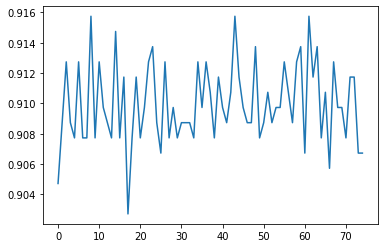

In [16]:
# plots DTC accuracy scores with default params
plt.plot(average_accuracy())

b. Criterion

Version 1 Average Accuracy Score:  0.910210631895687
Version 1 Standard Deviation:      0.002485952022559369

Version 2 Average Accuracy Score:  0.9111467736542962
Version 2 Standard Deviation:      0.0035813399863989107



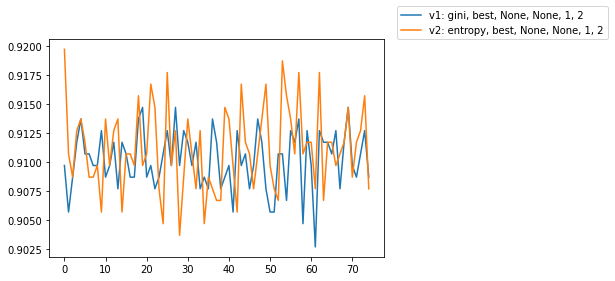

In [17]:
# plots DTC accuracy scores for each 'criterion' value option
plot_accuracy_comparison(c1 = 'gini', c2 = 'entropy')

# blue/version 1 is gini and orange/version 2 is entropy

Regardless of the criterion parameter's value, it seems that the accuracy score varies between runs (in no obvious pattern). In looking at the range for each criterion variable though, it seems like usually entropy tends to have a (slightly) larger range than gini does. Gini seems to vary more moderately (its range is smaller). From this, I believe that gini tends to return slightly more consistent accuracy scores while entropy has the potential to return either really high accuracy scores or really low accuracy scores (comparatively). Overall though, there is only a small difference in the average accuracy scores for each type of criterion value.

c. Splitter

Version 1 Average Accuracy Score:  0.9101571380809094
Version 1 Standard Deviation:      0.0029353436134149564

Version 2 Average Accuracy Score:  0.9073487128050819
Version 2 Standard Deviation:      0.007072976788437928



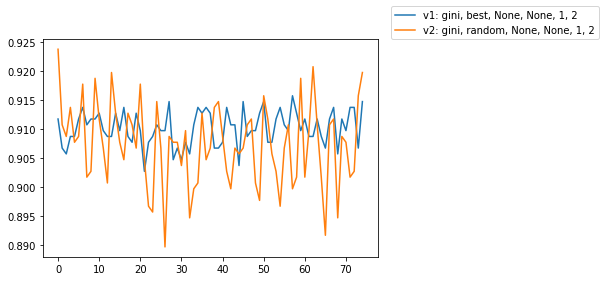

In [18]:
# plots DTC accuracy scores for each 'splitter' value option
plot_accuracy_comparison(s1 = 'best', s2 = 'random')

# blue/version 1 is best and orange/version 2 is random

Regardless of the splitter parameter's value, it seems that the accuracy score varies between runs (in no obvious pattern), just as it did when comparing the criterion values. In looking at the range for each splitter variable though, random seems to have the larger range of accuracy scores returned, meaning it is less consistent. This matches the name 'random' because the accuracy scores seem to reflect that with the larger range. On the other hand, best seems to vary more moderately (its range is usually significantly smaller). From this, I believe that best tends to return higher and more consistent accuracy scores while random has the potential to return either really high accuracy scores or really low accuracy scores, but with low consistence. Overall, there doesn't seem to be a significant difference in the average accuracy scores for each splitter value. There also doesn't seem to be that much of a difference between the average accuracy scores of the splitter values and criterion values. They are still very close to each other.

d. Random State

Version 1 Average Accuracy Score:  0.913741223671013
Version 1 Standard Deviation:      1.1102230246251565e-16



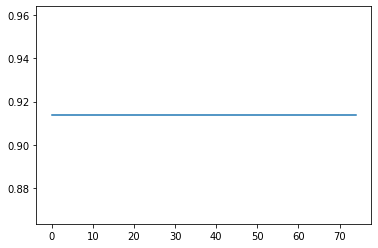

In [19]:
# plots DTC accuracy scores with random_state param changing value from 0-75
plt.plot(average_accuracy(r = True))

For all the random state values between 0-75, the accuracy score remains the same. This parameter doesn't seem to affect the accuracy score at all (at least on this scale, with the dataset I have). It is important to note, however, that the average accuracy score here tends to be a bit higher than it was for the criterion and splitter examples above.

e. Max Depth

Version 1 Average Accuracy Score:  0.9458375125376128
Version 1 Standard Deviation:      0.0



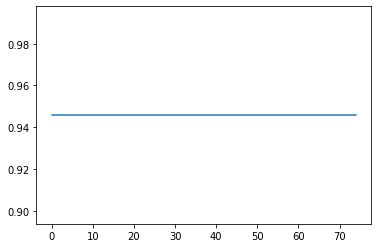

In [20]:
# plots DTC accuracy scores with max_depth param changing value from 1-76
plt.plot(average_accuracy(d = True))

For all the max depth values between 1-76, the accuracy score remains the same. This parameter doesn't seem to affect the accuracy score at all (at least on this scale, with the dataset I have). It is important to note, however, that the average accuracy score here is higher than it was for the criterion, splitter, and random state examples above. In fact, ~94% is similar to what I was getting on HW1 consistently with the logistic regression.

f. Min Samples Leaf

Version 1 Average Accuracy Score:  0.910785690404547
Version 1 Standard Deviation:      0.0025421524925030347



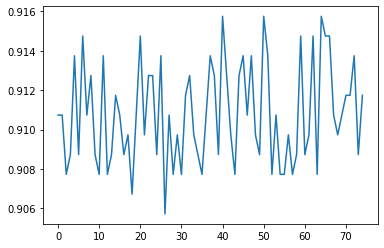

In [21]:
# plots DTC accuracy scores with min_samples_leaf param changing value from 1-76
plt.plot(average_accuracy(l = True))

For all the min samples leaf values between 1-76, the accuracy score seems to vary a decent amount. As a result, this parameter seems to affect the accuracy score directly. The average accuracy score is still similar to that of the criterion/splitter average accuracy scores though, so it doesn't seem to actually make that much of a difference with my current dataset/my project.

g. Min Samples Split

Version 1 Average Accuracy Score:  0.9098495486459378
Version 1 Standard Deviation:      0.0030465068014555014



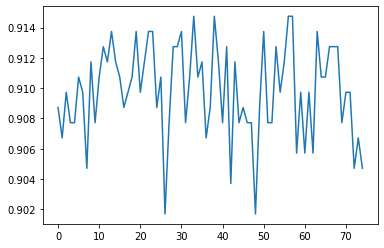

In [22]:
# plots DTC accuracy scores with min_samples_split param changing value from 2-77
plt.plot(average_accuracy(ss = True))

For all the min samples split values between 2-77, the accuracy score seems to vary a decent amount. As a result, this parameter seems to affect the accuracy score directly. The average accuracy score is still similar to that of the criterion/splitter/min samples leaf average accuracy scores though, so it doesn't seem to actually make that much of a difference with my current dataset/my project.

Out of all of the parameters I investigated above, most tend to produce similar average accuracy scores. The only parameter that stuck out was max depth because it had an average accuracy score that was nearly 3% higher than the others (which were all mostly within .1% of eachother). It was also interesting how reguardless of random state/max depth's value, all of the 75 accuracy scores produced are the same the entire time. I don't know why min samples leaf or min samples split would be so different. 

**Task 2: Compare Bagging & Boosting Ensemble Methods**

a. Bagging Algorithm

In [23]:
# bagging algorithm 
def bagging_alg(X, Y):
    bag_clf = BaggingClassifier()

    # evaluate with k-fold cross validation 
    cv = RepeatedStratifiedKFold() #n_splits = 10, n_repeats = 3, random_state = 1
    n_scores = cross_val_score(bag_clf, X, Y, scoring = 'accuracy', cv = cv) #, n_jobs = -1, error_score = 'raise'

    # print average of all accuracy scores
    print('Average Accuracy Score:  {}'.format(mean(n_scores)))
    print('Standard Deviation:      {}\n'.format(std(n_scores)))

bagging_alg(X_train, y_train)

Average Accuracy Score:  0.9464105029539163
Standard Deviation:      0.0031297269876083477



b. Boosting Algorithm

In [24]:
# boosting algorithm- ada classifier
def boosting_alg(X, Y):
    boost_clf = AdaBoostClassifier()

    # evaluate with k-fold cross validation
    cv = RepeatedStratifiedKFold()  #n_splits=10, n_repeats=3, random_state=1
    n_scores = cross_val_score(boost_clf, X, Y, scoring='accuracy', cv=cv)  #, n_jobs=-1, error_score='raise'

    # print average of all accuracy scores
    print('Average Accuracy Score:  {}'.format(mean(n_scores)))
    print('Standard Deviation:      {}\n'.format(std(n_scores)))

boosting_alg(X_train, y_train)

Average Accuracy Score:  0.9489210166264195
Standard Deviation:      0.0024041088608269603



c. Comparison

The results for both the Bagging algorithm and the Boosting algorithm are both very similar. Not only are both of the average accuracy scores within .01 of each other, but the standard deviation is also within .001 of each other. This goes to show how regardless of the optimizing algorithm used, the accuracy isn't significantly different. In comparison to the unoptimized results though, there does appear to be a significant difference (as the accuracy score rises nearly 3%).

**Part 3: Comparing the Effectiveness**

In [37]:
# calculating metrics from confusion matrix
def cm_metrics(version, clf):
    # make confusion matrix
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    # calculate reused values from matrix
    precision = cm[0][0]/(cm[0][0] + cm[0][1])
    recall = cm[0][0]/(cm[0][0] + cm[1][0])

    # output classification report
    print('Classification Report:\n{}\n'.format(classification_report(y_test, y_pred)))

    # output manual calculation from confusion matrix
    print('My Calculations from Confusion Matrix:\n\t{} Accuracy:     {}'.format(version, (cm[0][0] + cm[1][1])/(cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])))
    print('\t{} Precision:    {}'.format(version, precision))
    print('\t{} Recall:       {}'.format(version, recall))
    print('\t{} Specificity:  {}'.format(version, cm[1][1]/(cm[0][1] + cm[1][1])))
    print('\t{} F1 Score:     {}\n'.format(version, (2 * precision * recall) / (precision + recall)))

    # values should be similar between classification report & confusion matrix
    # i am just manually calculating to double check that I did it right though

From what it says online, accuracy is a good metric when the target variable classes in the data are nearly balanced. Here, that is not the case, as the majority of the people in the dataset have not had a stroke (95-96%) and a only a very small group has (4-5%).

For precision and recall, it is said that if the goal is to minimize false positives, then precision is an important metric (as you'd want it as close to 100% as possible). Alternatively, if the goal is to minimize false negatives, then recall would be the more important metric (as we would then want it to be as close to 100% as possible, instead of precision). I think that recall would be the more important metric for this dataset since it is health-related and I believe it would be better to anticipate someone having a stroke (and then they don't as opposed to anticipating someone will not have a stroke (and then they do). 

Specificity is the exact opposite of recall, and since I said above that I believe recall would be a good metric, I don't believe that specificity really would be.

Lastly, the F1 score balances out precision and recall. I think that this would be the best metric since it considers both false negatives and false positives. I do believe recall is a bit more important with this particular dataset, but the F1 score would also be a good option in my opinion.

As a result, the metric I am going to use is the F1 score. It takes more into consideration than recall alone, and so I think it is a reliable metric to choose.

a. Decision Tree Classifier Metrics

In [40]:
# getting metrics for bagging algorithm
cm_metrics('Decision Tree', DecisionTreeClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       943
           1       0.09      0.07      0.08        54

    accuracy                           0.91       997
   macro avg       0.52      0.51      0.52       997
weighted avg       0.90      0.91      0.90       997


My Calculations from Confusion Matrix:
	Decision Tree Accuracy:     0.9077231695085256
	Decision Tree Precision:    0.9554612937433722
	Decision Tree Recall:       0.9474237644584648
	Decision Tree Specificity:  0.08695652173913043
	Decision Tree F1 Score:     0.9514255543822596



b. Bagging Algorithm Metrics

In [38]:
# getting metrics for bagging algorithm
cm_metrics('Bagging', BaggingClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       943
           1       0.00      0.00      0.00        54

    accuracy                           0.94       997
   macro avg       0.47      0.50      0.49       997
weighted avg       0.89      0.94      0.92       997


My Calculations from Confusion Matrix:
	Bagging Accuracy:     0.9418254764292878
	Bagging Precision:    0.9957582184517497
	Bagging Recall:       0.945619335347432
	Bagging Specificity:  0.0
	Bagging F1 Score:     0.9700413223140495



c. Boosting Algorithm Metrics

In [39]:
# getting metrics for boosting algorithm
cm_metrics('Boosting', AdaBoostClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       943
           1       0.00      0.00      0.00        54

    accuracy                           0.94       997
   macro avg       0.47      0.50      0.48       997
weighted avg       0.89      0.94      0.92       997


My Calculations from Confusion Matrix:
	Boosting Accuracy:     0.9408224674022067
	Boosting Precision:    0.9946977730646872
	Boosting Recall:       0.9455645161290323
	Boosting Specificity:  0.0
	Boosting F1 Score:     0.9695090439276487



d. Conclusion

For the Decision Tree, Bagging algorithm, and Boosting algorithm, the F1 score matches between the classification report and my manual calculations. For the Decision Tree, the F1 score is 95%, whereas for the Bagging & Boosting algorithms, the F1 score is ~97%. This shows a clear increase when the optimization algorithms are used, which makes sense. 

It is also worth noting that for the Bagging & Boosting algorithms, the scores for accuracy, precision, recall, and specificity are also nearly identical. This makes sense since their scores in Part 2 were also nearly identical, so it is not very surprising. What this means, though, is that mainly differences in the Decision Tree metrics will show whether choosing a different metric would've impacted my results differently.

In both the Bagging & Boosting algorithms, the accuracy and recall have similar values. The most notable difference in the Decision Tree metrics, however, are that there is a quite significant difference between the values of accuracy and recall. Accuracy is ~90% whereas recall is ~94% (just as it is in the metrics for the Bagging & Boosting algorithms). This stands out to me since none of the other values for the Decision Tree's metrics match those of the optimization algorithm's metrics (besides for recall).

As mentioned above, recall seemed to be one of the most important metrics to me, so if I had chosen recall I would observe that it has the same value between all 3 models. Alternatively, with the metric I chose though (F1 score), I do not see that.